Project: Analyse A/B revenue test 

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import datetime as dt

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import scipy.stats as stats

import warnings

In [2]:
orders = pd.read_csv('C:/Users/gudin/Desktop/Project files/A_B revenue analysis/orders.csv')
visitors = pd.read_csv('C:/Users/gudin/Desktop/Project files/A_B revenue analysis/visitors.csv')

In [3]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
orders.duplicated().sum()

0

In [5]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders.head(0)

,transaction_id,visitor_id,date,revenue,group


In [6]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
visitors.duplicated().sum()

0

Our datasets have no missing data and no duplicates. Lets move on and create common table with aggregatet parameters of visitors and orders

In [8]:
DateGroup = orders[['date', 'group']].drop_duplicates()

ordersAgg = DateGroup.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max', 
          'group' : 'max', 
          'transaction_id' : 'nunique', 
          'visitor_id' : 'nunique', 
          'revenue' : 'sum'}), axis=1
).sort_values(by=['date','group'])

visitorsAgg = DateGroup.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max', 
          'group' : 'max', 
          'visitors' : 'sum'}), axis=1
).sort_values(by=['date','group'])

In [9]:
AllData = ordersAgg.merge(visitorsAgg, on=['date', 'group'])

AllData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

AllData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Now we can make cumulative conversion and revenue graphs and analyse them

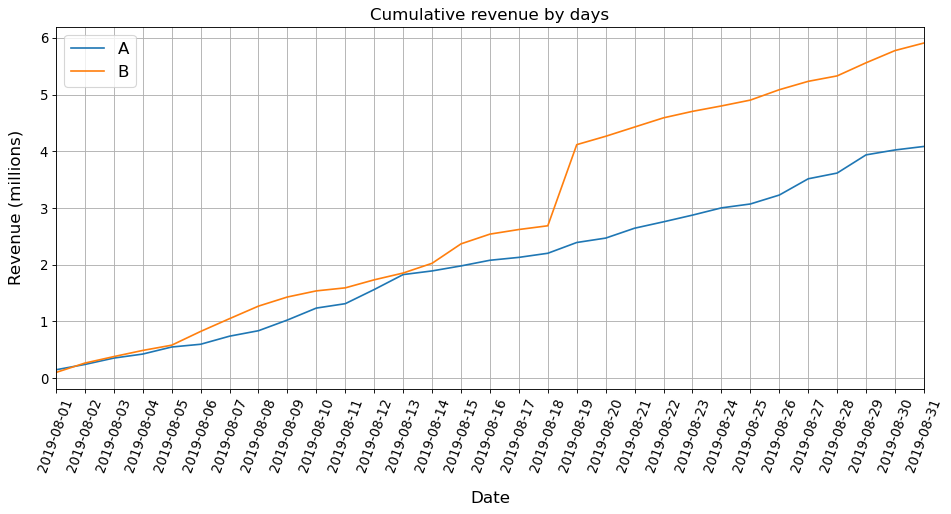

In [10]:
Revenue_A = AllData[AllData['group'] == 'A'][['date','revenue', 'orders']]
Revenue_B = AllData[AllData['group'] == 'B'][['date','revenue', 'orders']]

figure(figsize=(14, 6), dpi=80)

plt.plot(Revenue_A['date'], Revenue_A['revenue']/1000000, label='A')
plt.plot(Revenue_B['date'], Revenue_B['revenue']/1000000, label='B')

plt.xticks(rotation=70, size=12)
plt.yticks(size=12)
plt.title('Cumulative revenue by days', size=15)
plt.ylabel('Revenue (millions)', size=15, labelpad=15)
plt.xlabel('Date', size=15, labelpad=15)
plt.grid()
plt.xlim(['2019-08-01', '2019-08-31']) #ограничение по осям
plt.legend(fontsize=15)

Both groups show stable increasement, however there is a spike in goup 'B' from 2019-08-18 to 2019-08-19 which may reveal some "spikes" in data later

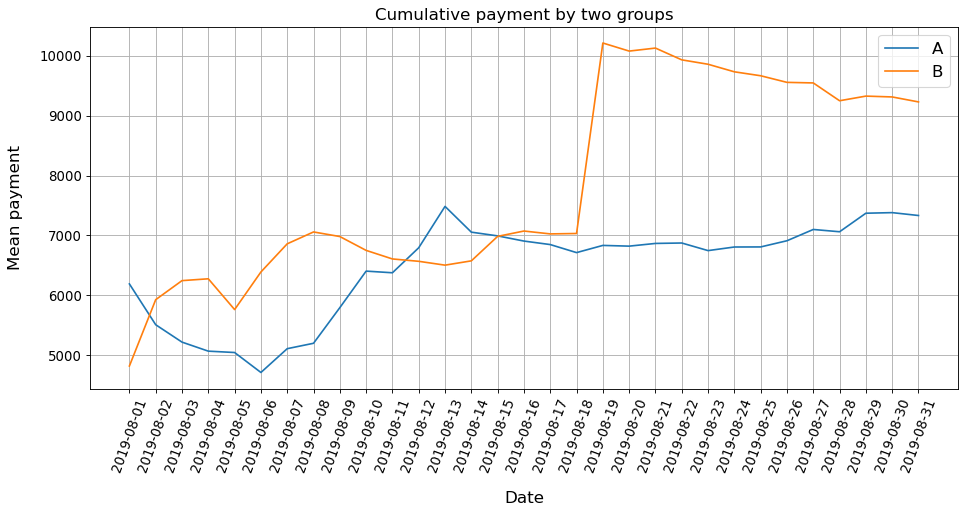

In [11]:
figure(figsize=(14, 6), dpi=80)

plt.plot(Revenue_A['date'], Revenue_A['revenue']/Revenue_A['orders'], label='A')
plt.plot(Revenue_B['date'], Revenue_B['revenue']/Revenue_B['orders'], label='B')

plt.xticks(rotation=70, size=12)
plt.yticks(size=12)
plt.title('Cumulative payment by two groups', size=15)
plt.ylabel('Mean payment', size=15, labelpad=15)
plt.xlabel('Date', size=15, labelpad=15)
plt.grid()

plt.legend(fontsize=15)

We can once again see sudden rise in group 'B' which indicates that there are some rare and high values in our data

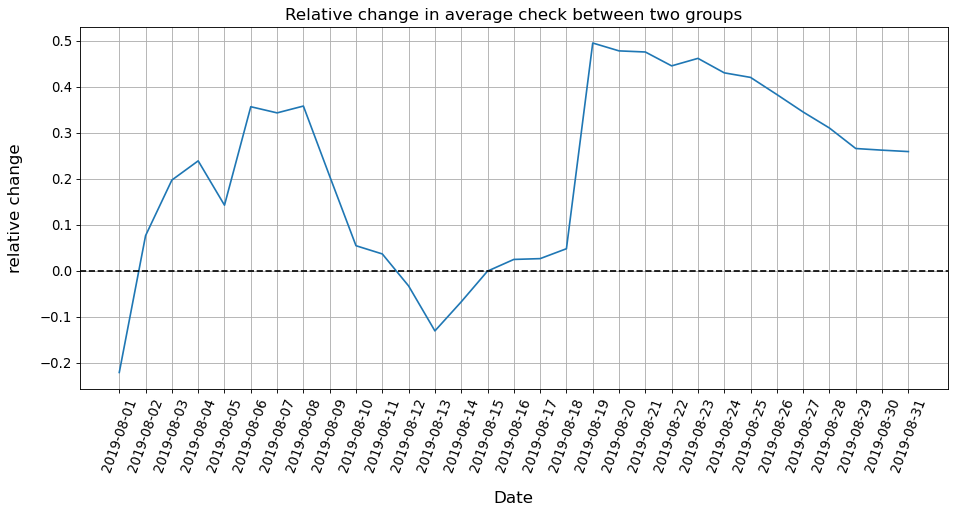

In [12]:
Merged_Revenue = Revenue_A.merge(Revenue_B, on='date', how='left', suffixes=['A', 'B'])

figure(figsize=(14, 6), dpi=80)

plt.plot(Merged_Revenue['date'], 
         (Merged_Revenue['revenueB']/Merged_Revenue['ordersB'])/(Merged_Revenue['revenueA']/Merged_Revenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=70, size=12)
plt.yticks(size=12)
plt.title('Relative change in average check between two groups', size=15)
plt.ylabel('relative change', size=15, labelpad=15)
plt.xlabel('Date', size=15, labelpad=15)
plt.grid()

We can see that our data is not stable, even though it shows mostly good tendencies.

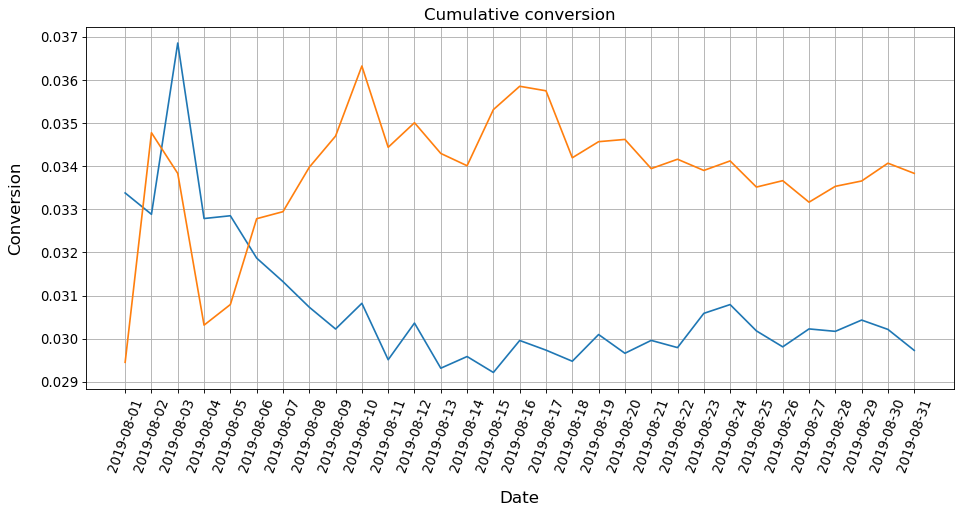

In [13]:
AllData['conversion'] = AllData['orders'] / AllData['visitors']

AllData_A = AllData[AllData['group'] == 'A']
AllData_B = AllData[AllData['group'] == 'B']

figure(figsize=(14, 6), dpi=80)

plt.plot(AllData_A['date'], AllData_A['conversion'], label='A')
plt.plot(AllData_B['date'], AllData_B['conversion'], label='B')

plt.xticks(rotation=70, size=12)
plt.yticks(size=12)
plt.title('Cumulative conversion', size=15)
plt.ylabel('Conversion', size=15, labelpad=15)
plt.xlabel('Date', size=15, labelpad=15)
plt.grid()

We can see that group 'A' slowly falls while group 'B' keeps high values

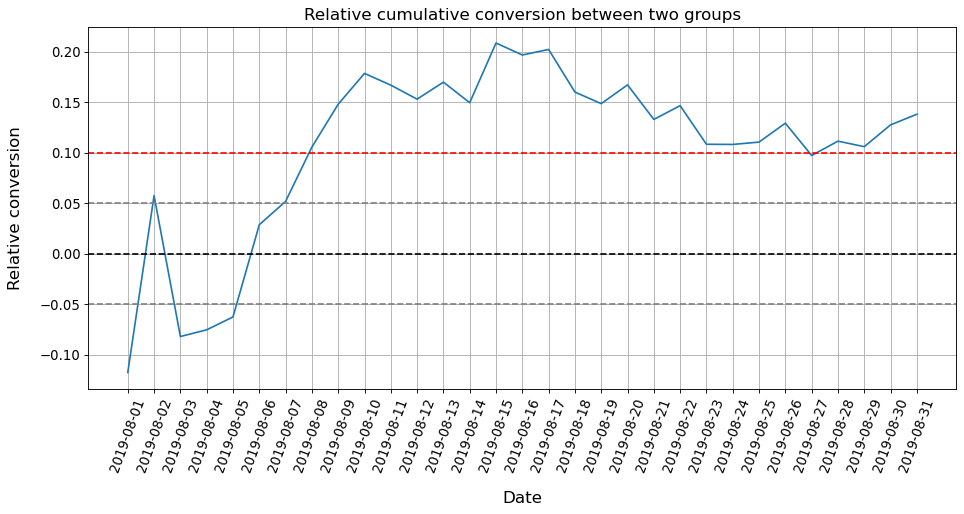

In [14]:
Merged_Conversion = AllData_A[['date','conversion']].merge(
    AllData_B[['date','conversion']], on='date', how='left', suffixes=['A', 'B'])

figure(figsize=(14, 6), dpi=80)

plt.plot(Merged_Conversion['date'], Merged_Conversion['conversionB'] / Merged_Conversion['conversionA'] - 1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.05, color='grey', linestyle='--')
plt.axhline(y=0.05, color='grey', linestyle='--')
plt.axhline(y=0.1, color='red', linestyle='--')

plt.xticks(rotation=70, size=12)
plt.yticks(size=12)
plt.title('Relative cumulative conversion between two groups', size=15)
plt.ylabel('Relative conversion', size=15, labelpad=15)
plt.xlabel('Date', size=15, labelpad=15)
plt.grid()

This graph shows that group 'B's conversion is much higher than of group 'A'

Looking at all those graphs we can clearly see that group 'B' has some huge outliers that skew our data in the wrong direction

Lets find out those outliers

Lets look at users and number of orders

In [15]:
OrdersToUsers = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
OrdersToUsers.columns = ['visitor_id', 'orders']
OrdersToUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


As we see two users made 11 orders, another two made 9 and 8 orders while other users made 5 or less

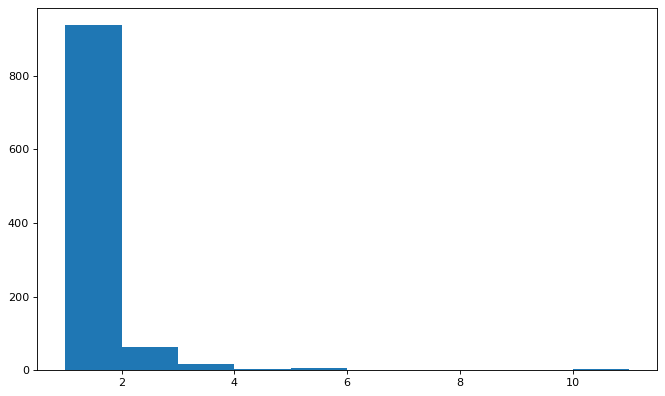

In [16]:
figure(figsize=(10, 6), dpi=80)

plt.hist(OrdersToUsers['orders'])

plt.show()

Histigram clearly shows that there are majority of users with 1 to 4 orders and small number of those with more than 5 orders

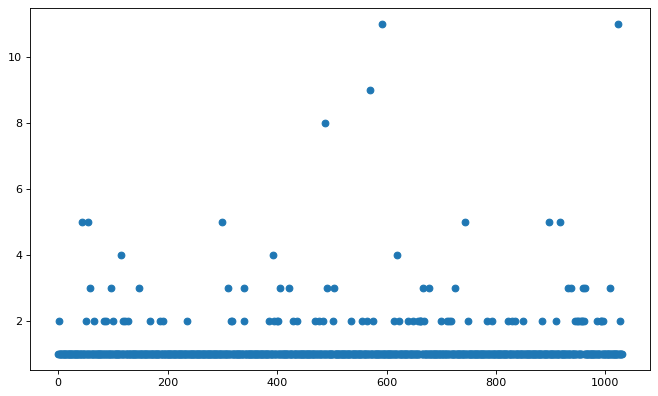

In [17]:
figure(figsize=(10, 6), dpi=80)

plt.scatter(pd.Series(range(0, (len(OrdersToUsers)))), OrdersToUsers['orders'])

plt.show()

Users mostly make 1 to 4-5 orders. Outliers seems to be connected to those few who made more than 5 orders

In [18]:
np.percentile(OrdersToUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

And we can reassure ourselves by looking at percentiles - less then 1% of users made more than 4 orders

Lets look at order prices

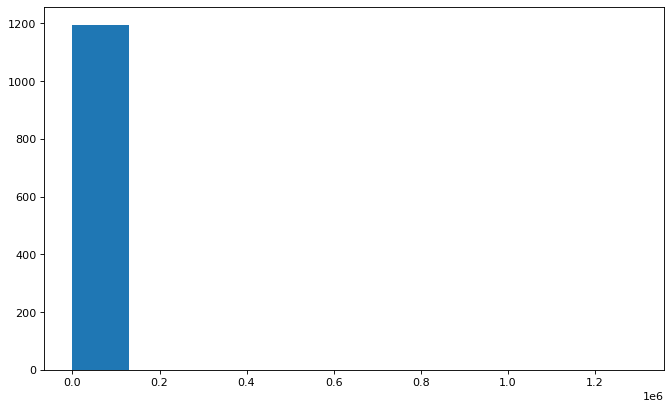

In [19]:
figure(figsize=(10, 6), dpi=80)

plt.hist(orders['revenue'])

plt.show()

Unfortunately that histogram didn't provide us any answers, lets mdify it a bit

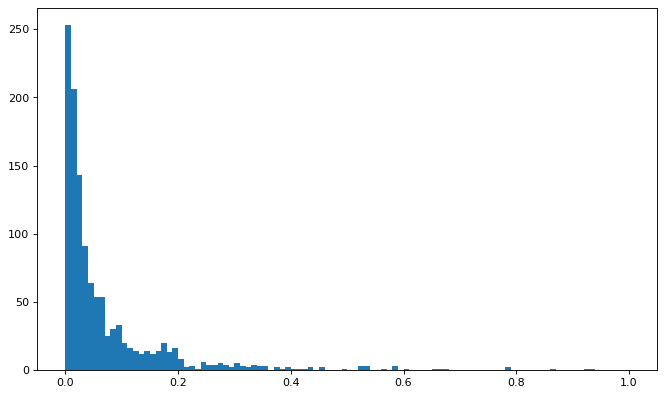

In [20]:
figure(figsize=(10, 6), dpi=80)

plt.hist(orders['revenue']/100000, bins=100, range=(0, 1))

plt.show()

Here we can see that mostly orders do not cost more than 20-40 thousand, however there are few that go up to 100 thousand

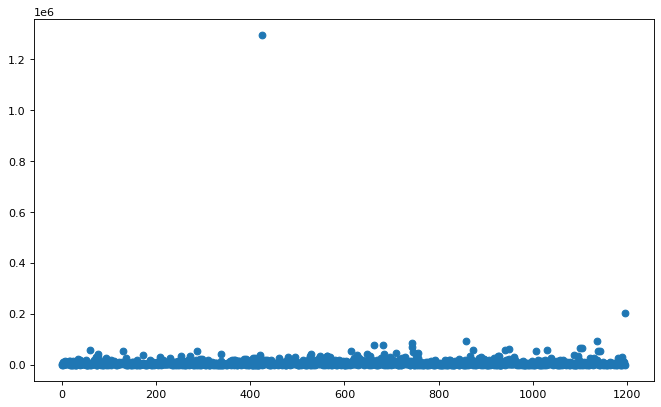

In [21]:
figure(figsize=(10, 6), dpi=80)

plt.scatter(pd.Series(range(0, (len(orders)))), orders['revenue'])

plt.show()

Scatter plot shows us that there are outlier in order prices

In [22]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

Percentiles gives us clear picturre of how much users payed for orders

Before we conduct statistical analysis, we once again need to make a common table with visitors, revenue and orders

In [23]:
visitors_A = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A.columns = ['date', 'visitors_A']

All_visitors_A = visitors_A.apply(
    lambda x: visitors_A[visitors_A['date'] <= x['date']].agg(
        {'date': 'max', 
         'visitors_A': 'sum'}), 
    axis=1)

All_visitors_A.columns = ['date', 'All_visitors_A']


visitors_B = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B.columns = ['date', 'visitors_B']

All_visitors_B = visitors_B.apply(
    lambda x: visitors_B[visitors_B['date'] <= x['date']].agg(
        {'date': 'max', 
         'visitors_B': 'sum'}), 
    axis=1)

All_visitors_B.columns = ['date', 'All_visitors_B']

In [24]:
orders_A = orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']].groupby(
    'date', as_index=False).agg({'transaction_id':'nunique', 'revenue':'sum'})

orders_A.columns = ['date', 'orders_A', 'revenue_A']

All_orders_A = orders_A.apply(lambda x: orders_A[orders_A['date'] <= x['date']]
                              .agg({'date':'max', 'orders_A':'sum', 'revenue_A':'sum'}), axis=1).sort_values(by='date')

All_orders_A.columns = ['date', 'All_orders_A', 'All_revenue_A']

In [25]:
orders_B = orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']].groupby(
    'date', as_index=False).agg({'transaction_id':'nunique', 'revenue':'sum'})

orders_B.columns = ['date', 'orders_B', 'revenue_B']

All_orders_B = orders_B.apply(lambda x: orders_B[orders_B['date'] <= x['date']]
                              .agg({'date':'max', 'orders_B':'sum', 'revenue_B':'sum'}), axis=1).sort_values(by='date')

All_orders_B.columns = ['date', 'All_orders_B', 'All_revenue_B']

In [26]:
data = (
    orders_A.merge(orders_B, on='date', how='left')
    .merge(All_orders_A, on='date', how='left')
    .merge(All_orders_B, on='date', how='left')
    .merge(visitors_A, on='date', how='left')
    .merge(visitors_B, on='date', how='left')
    .merge(All_visitors_A, on='date', how='left')
    .merge(All_visitors_B, on='date', how='left')
)

data.head(5)

,date,orders_A,revenue_A,orders_B,revenue_B,All_orders_A,All_revenue_A,All_orders_B,All_revenue_B,visitors_A,visitors_B,All_visitors_A,All_visitors_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [27]:
orders_users_A = (orders[orders['group'] == 'A']
                  .groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'}))
orders_users_A.columns = ['user_id', 'orders']


orders_users_B = (orders[orders['group'] == 'B']
                  .groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'}))
orders_users_B.columns = ['user_id', 'orders']

In [28]:
sample_A = pd.concat(
    [orders_users_A['orders'], pd.Series(
        0, index=np.arange(data['visitors_A'].sum() - len(orders_users_A['orders'])), name='orders')], axis=0)

sample_B = pd.concat(
    [orders_users_B['orders'],pd.Series(
        0, index=np.arange(data['visitors_B'].sum() - len(orders_users_B['orders'])), name='orders')], axis=0)

Now we can do statistical analysis using Mann–Whitney U test

In [29]:
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sample_A, sample_B)[1]))
print('')
print('percent difference between two groups:', "{0:.2%}".format(sample_B.mean() / sample_A.mean() - 1))

p-value: 0.017

percent difference between two groups: 13.81%


Our p-value is less than 0.05 which means that there are statistical differences between two groups

Lets make a hypothesis

H0: there are no statistical differences between two groups in average check

H1: there are statistical differences between two groups in average check

In [30]:
print('p-value:', '{0:.3f}'
      .format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])
     )

print('')

print('percent difference between two groups:', '{0:.2%}'
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)
     )

p-value: 0.729

percent difference between two groups: 25.87%


Our p-value is more than 0.05, therefore we can't abandon our Null hypothesis, there are no statistical differences on average check between two groups

Lets find our how much abnormal users do we have

In [31]:
abnormal_orders = np.percentile(OrdersToUsers['orders'], [95])[0]
abnormal_revenue = np.percentile(orders['revenue'], [95])[0]

many_orders = pd.concat(
    [
        orders_users_A[orders_users_A['orders'] > abnormal_orders]['user_id'],
        orders_users_B[orders_users_B['orders'] > abnormal_orders]['user_id']
    ], axis=0
)

expensive_orders = orders[orders['revenue'] > abnormal_revenue]['visitor_id']

abnormal_users = (pd.concat([many_orders, expensive_orders], axis=0).drop_duplicates().sort_values())

print(abnormal_users.head(5))
print('')
print('number of abnormal users:', abnormal_users.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64

number of abnormal users: 74


In [32]:
orders['visitor_id'].nunique()

1031

having 1031 unique users with 74 abnormal ones means that only 7% of all users are abnormal.

Because it is not a huge number - we can get rid of them to clean our data and look how it will affect everything else

In [33]:
sample_A_filtered = (
    pd.concat([orders_users_A[np.logical_not(orders_users_A['user_id'].isin(abnormal_users))]['orders'],
             pd.Series(0, index=np.arange(data['visitors_A'].sum() - len(orders_users_A['orders'])), 
                       name = 'orders')], axis=0)
)


sample_B_filtered = (
    pd.concat([orders_users_B[np.logical_not(orders_users_B['user_id'].isin(abnormal_users))]['orders'],
             pd.Series(0, index=np.arange(data['visitors_B'].sum() - len(orders_users_B['orders'])), 
                       name = 'orders')], axis=0)
)

Lets look at statistical differences between two groups once again after we cleaned our data

In [34]:
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print('')
print('percent difference between two groups:', "{0:.2%}".format(sample_B_filtered.mean() / sample_A_filtered.mean() - 1))

p-value: 0.013

percent difference between two groups: 17.27%


Our p-value was reduced from 0.017 to 0.013 but statistical difference grew from 13.81% to 17.27%

Lets try our hypothesis about statistical difference once again on cleaned data

H0: there is statistical difference between two groups

H1: there is no statistical difference between two groups

In [35]:
print('p-value:', '{0:.3f}'
      .format(stats.mannwhitneyu(orders[np.logical_and(
          orders['group']=='A', np.logical_not(orders['visitor_id'].isin(abnormal_users))
     )]['revenue'], orders[np.logical_and(
          orders['group']=='B', np.logical_not(orders['visitor_id'].isin(abnormal_users))
     )]['revenue'])[1]))

print('')

print('percent difference between two groups:', '{0:.2%}'
      .format(orders[np.logical_and(orders['group'] == 'B', np.logical_not(
          orders['visitor_id'].isin(abnormal_users)))
        ]['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A', np.logical_not(
          orders['visitor_id'].isin(abnormal_users))
            )
        ]['revenue'].mean() - 1))

p-value: 0.738

percent difference between two groups: -1.96%


Even though p-value didn't change that much (0.738 on cleaned data vs 0.729 on 'raw' data), percent on statistical difference dropped down from 25.87% to -1.96% which clearly indicates that those outlier were responsible for statistical differense in average user check